# Train the model

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pymc3 as pm
from scipy.stats import poisson, mode
import seaborn as sns
import theano.tensor as tt
from multiprocessing import Pool

%matplotlib inline

In [29]:
training_df = pd.read_csv('../data/bra_serie_A_results.csv')
training_df = training_df.dropna()

In [30]:
teams = training_df['home_team'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

training_df = pd.merge(training_df, teams, left_on='home_team', right_on='team', how='left')
training_df = training_df.rename(columns={'i': 'i_home'}).drop('team', 1)
training_df = pd.merge(training_df, teams, left_on='away_team', right_on='team', how='left')
training_df = training_df.rename(columns={'i': 'i_away'}).drop('team', 1)

observed_home_goals = training_df['home_score'].values
observed_away_goals = training_df['away_score'].values

home_team = training_df['i_home'].values
away_team = training_df['i_away'].values

num_teams = len(training_df['i_home'].drop_duplicates())
num_games = len(home_team)

g = training_df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = training_df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [31]:
with pm.Model() as model:
    # global model parameters
    home = pm.Normal('home', 0, 0.0001)
    tau_att = pm.Gamma('tau_att', .1, .1)
    tau_def = pm.Gamma('tau_def', .1, .1)
    intercept = pm.Normal('intercept', 0, 0.0001)
    
    # team specific parameters
    atts_star = pm.Normal('atts_star', mu=0, tau=tau_att, shape=num_teams)
    defs_star = pm.Normal('defs_star', mu=0, tau=tau_def, shape=num_teams)
    
    #
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


## Fit the Model

 [-----------------100%-----------------] 2000 of 2000 complete in 13.1 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21c0ef1810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f21bfff4710>]], dtype=object)

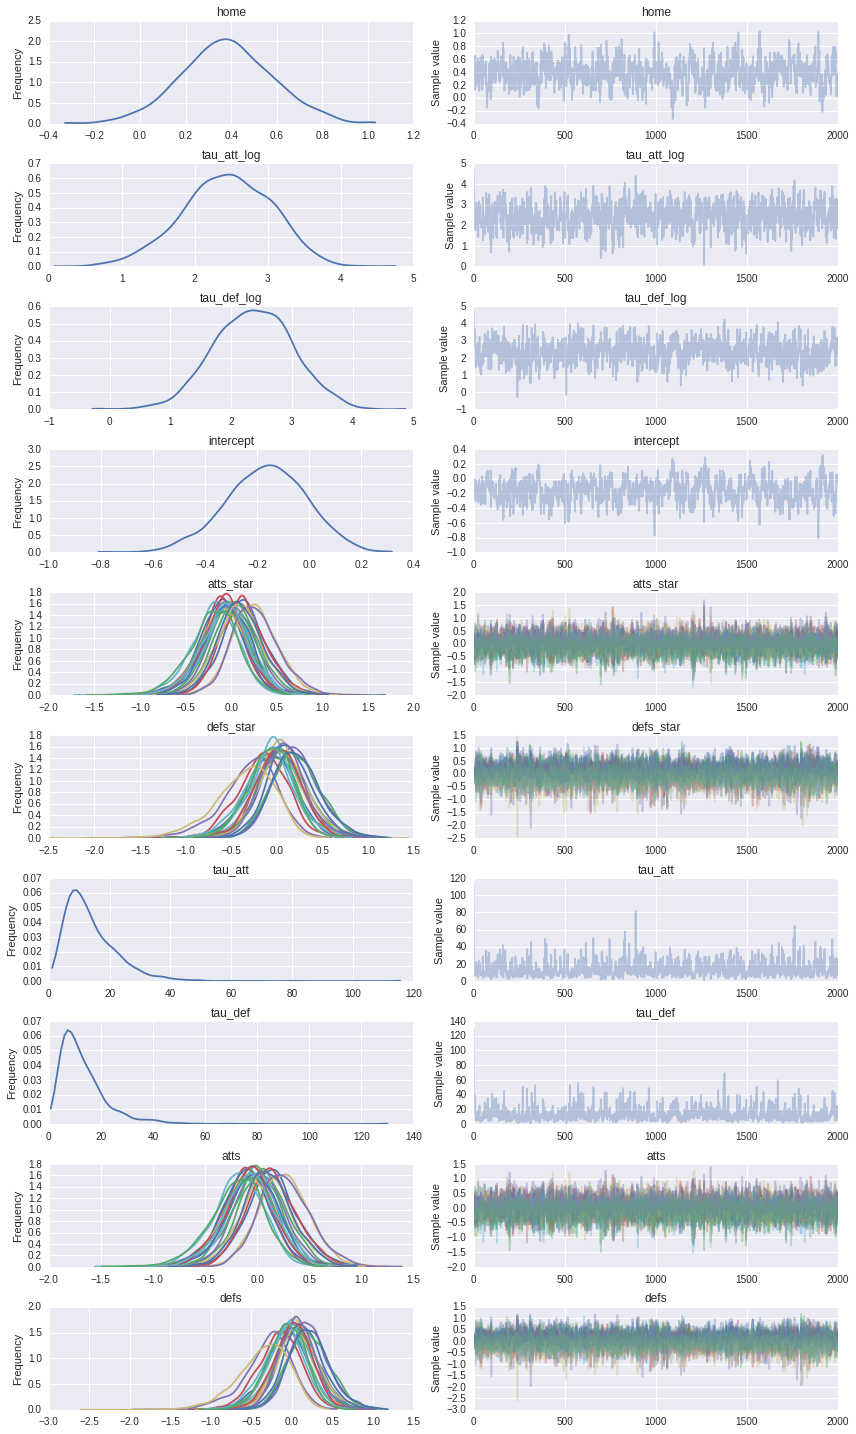

In [32]:
with model:
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, njobs=1)
    
pm.traceplot(trace)

In [40]:
atts_df = pd.DataFrame(trace.get_values('atts'), columns=teams.team.values.tolist())
defs_df = pd.DataFrame(trace.get_values('defs'), columns=teams.team.values.tolist())
home_df = pd.DataFrame(trace.get_values('home'), columns=['home']) #, columns=teams.team.values.tolist())
intercept_df = pd.DataFrame(trace.get_values('intercept'), columns=['intercept']) #, columns=teams.team.values.tolist())
atts_df.columns = ['atts_{}'.format(name) for name in atts_df.columns]
defs_df.columns = ['defs_{}'.format(name) for name in defs_df.columns]
params_df = pd.concat([atts_df, defs_df, home_df, intercept_df], axis=1, join='inner')

# Make Predictions

In [56]:
import pandas as pd
import numpy as np
from scipy.stats import poisson

def tau(xx, yy, lambda_param, mu, rho):
    if xx == 0 & yy == 0:
        return 1 - (lambda_param*mu*rho)
    elif xx == 0 & yy== 1:
        return 1 + (lambda_param * rho)
    elif xx == 1 & yy == 0:
        return 1 + (1 + (mu * rho))
    elif xx == 1 & yy == 1:
        return 1 - rho
    else:
        return 1

def calculate_mu(home_team_name, away_team_name, param_df, row_num):
    '''
    This function calculates the mu value for the given combination of home team and away team,
    given the param_df
    '''
    home_atts = param_df['atts_{0}'.format(home_team_name)].iloc[row_num]
    home_defs = param_df['defs_{0}'.format(home_team_name)].iloc[row_num]
    away_atts = param_df['atts_{0}'.format(away_team_name)].iloc[row_num]
    away_defs = param_df['defs_{0}'.format(away_team_name)].iloc[row_num]
    intercept = param_df['intercept'].iloc[row_num]
    home = param_df['home'].iloc[row_num]
    mu = np.exp(home_atts + away_defs + home + intercept)
    return mu

def calculate_lambda_val(home_team_name, away_team_name, param_df, row_num):
    '''
    This function calculates the lambda value for the given combination of home team and away team,
    given the param_df
    '''
    home_atts = param_df['atts_{0}'.format(home_team_name)].iloc[row_num]
    home_defs = param_df['defs_{0}'.format(home_team_name)].iloc[row_num]
    away_atts = param_df['atts_{0}'.format(away_team_name)].iloc[row_num]
    away_defs = param_df['defs_{0}'.format(away_team_name)].iloc[row_num]
    intercept = param_df['intercept'].iloc[row_num]
    lambda_val = np.exp(away_atts + home_defs + intercept)
    return lambda_val

def create_scaling_matrix(mu, lambda_val, rho):
    '''
    '''
    results = []
    for xx, yy in zip([0, 1, 0, 1], [0, 0, 1, 1]):
        results.append(tau(xx, yy, lambda_param=lambda_val, mu=mu, rho=rho))

    result_array = np.array(results)
    result_matrix = result_array.reshape(2, 2)
    result_matrix = result_matrix.transpose()
    return result_matrix


def create_likelihood_matrix(mu, lambda_val, max_goals=6):
    '''
    '''
    home_dist = poisson(mu).pmf([x for x in xrange(max_goals)])
    away_dist = poisson(lambda_val).pmf([x for x in xrange(max_goals)])
    #
    # need to clearl define the shapes for home_dist and away_dist
    home_dist.shape = (6, 1)
    away_dist.shape = (6, 1)

    result_matrix = np.matmul(home_dist, away_dist.transpose())

    return result_matrix

def get_fixture_result(result_matrix, scaling_matrix):
    '''
    This function takes the result matric and the scaling matrix for a given
    fixture and returns a dictionary with the home / draw / away probabilities.
    '''
    result_matrix[0:2, 0:2] = np.dot(result_matrix[0:2, 0:2], scaling_matrix.transpose())
    home_abs = np.sum(np.tril(result_matrix))
    draw_abs = np.sum(np.diag(result_matrix))
    away_abs = np.sum(np.triu(result_matrix))

    # transform to probabilities
    total_absolute = home_abs + draw_abs + away_abs
    home_prob = ((home_abs / total_absolute) * 100)
    draw_prob = ((draw_abs / total_absolute) * 100)
    away_prob = ((away_abs / total_absolute) * 100)

    result_dict = {
        'home_prob': home_prob,
        'draw_prob': draw_prob,
        'away_prob': away_prob}

    return result_dict

def calculate_fixture_result(fixture_row, param_df, home_team_name,
    away_team_name, row_num):
    '''
    Using the param_df, calculate the home_prob, draw_prob, and away_prob.
    '''
    mu = calculate_mu(home_team_name, away_team_name, param_df, row_num)
    lambda_val = calculate_lambda_val(home_team_name, away_team_name,
        param_df, row_num)
    result_matrix = create_likelihood_matrix(mu, lambda_val)
    rho = params_df['home'].iloc[row_num]

    scaling_matrix = create_scaling_matrix(mu, lambda_val, rho)
    result_dict = get_fixture_result(result_matrix, scaling_matrix)
    result_dict['home_team_name'] = home_team_name
    result_dict['away_team_name'] = away_team_name

    return result_dict

def make_predictions_from_fixture_list(fixture_df, param_df, row_num):
    '''
    From a list of fixtures, and a dataframe of prediction parameters, and the
    row_num to sample from, return a dataframe with a row for each fixture.
    This must contain home team,away team, home win probability, draw
    probability, and away probability.
    '''
    home_team_list = []
    away_team_list = []
    home_prob_list = []
    draw_prob_list = []
    away_prob_list = []
    for row in fixture_df.iterrows():
        fixture_row = row[1]
        home_team_name = fixture_row['home_team']
        away_team_name = fixture_row['away_team']
        fixture_result_dict = calculate_fixture_result(fixture_row, param_df,
            home_team_name, away_team_name, row_num)
        home_team_list.append(fixture_result_dict['home_team_name'])
        away_team_list.append(fixture_result_dict['away_team_name'])
        home_prob_list.append(fixture_result_dict['home_prob'])
        draw_prob_list.append(fixture_result_dict['draw_prob'])
        away_prob_list.append(fixture_result_dict['away_prob'])

    data = {'home_team': home_team_list,
            'away_team': away_team_list,
            'home_prob': home_prob_list,
            'draw_prob': draw_prob_list,
            'away_prob': away_prob_list
            }
    predictions_df = pd.DataFrame(data)
    return predictions_df




In [60]:
training_df.home_team.unique()

array(['Palmeiras', 'Flamengo', 'Atl\xe9tico Mineiro', 'Coritiba',
       'Santa Cruz', 'Botafogo', 'Am\xe9rica Mineiro', 'Figueirense',
       'Corinthians', 'Internacional', 'Ponte Preta', 'Fluminense',
       'Cruzeiro', 'Atl\xe9tico PR', 'Santos', 'Chapecoense', 'Gr\xeamio',
       'S\xe3o Paulo', 'Vit\xf3ria', 'Sport Recife'], dtype=object)

In [61]:

fixture_data = {'home_team': ['Santos', 'Cruzeiro', 'Fluminense', 'S\xe3o Paulo', 'Gr\xeamio', 
                              'Chapecoense', 'Vit\xf3ria', 'Sport Recife', 'Atl\xe9tico PR'],
                'away_team': ['Figueirense', 'Santa Cruz', 'Palmeiras', 'Coritiba', 'Atl\xe9tico Mineiro', 
                              'Flamengo', 'Am\xe9rica Mineiro', 'Internacional', 'Botafogo']}
fixture_df = pd.DataFrame(fixture_data)
fixture_df.head()

,away_team,home_team
0,Figueirense,Santos
1,Santa Cruz,Cruzeiro
2,Palmeiras,Fluminense
3,Coritiba,S�o Paulo
4,Atl�tico Mineiro,Gr�mio


In [49]:
def make_predictions_from_fixture_list(fixture_df, param_df, row_num):
    '''
    From a list of fixtures, and a dataframe of prediction parameters, and the
    row_num to sample from, return a dataframe with a row for each fixture.
    This must contain home team,away team, home win probability, draw
    probability, and away probability.
    '''
    home_team_list = []
    away_team_list = []
    home_prob_list = []
    draw_prob_list = []
    away_prob_list = []
    for row in fixture_df.iterrows():
        fixture_row = row[1]
        home_team_name = fixture_row['home_team']
        away_team_name = fixture_row['away_team']
        fixture_result_dict = calculate_fixture_result(fixture_row, param_df,
            home_team_name, away_team_name)
        home_team_list.append(fixture_result_dict['home_team_name'])
        away_team_list.append(fixture_result_dict['away_team_name'])
        home_prob_list.append(fixture_result_dict['home_prob'])
        draw_prob_list.append(fixture_result_dict['draw_prob'])
        away_prob_list.append(fixture_result_dict['away_prob'])

    data = {'home_team': home_team_list,
            'away_team': away_team_list,
            'home_prob': home_prob_list,
            'draw_prob': draw_prob_list,
            'away_prob': away_prob_list
            }
    predictions_df = pd.DataFrame(data)
    return predictions_df

In [62]:
predicted_df = make_predictions_from_fixture_list(fixture_df, params_df, row_num=1500)

In [63]:
predicted_df

,away_prob,away_team,draw_prob,home_prob,home_team
0,40.540933,Figueirense,19.680045,39.779022,Santos
1,41.869233,Santa Cruz,18.777877,39.352890,Cruzeiro
2,34.028078,Palmeiras,19.878702,46.093220,Fluminense
3,33.620299,Coritiba,21.495295,44.884407,S�o Paulo
4,28.081288,Atl�tico Mineiro,18.727028,53.191684,Gr�mio
5,36.904265,Flamengo,21.972558,41.123177,Chapecoense
6,31.179082,Am�rica Mineiro,15.583385,53.237533,Vit�ria
7,49.571934,Internacional,22.245143,28.182923,Sport Recife
8,44.036943,Botafogo,20.796826,35.166231,Atl�tico PR
